# Set up notebook

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sc = pyspark.SparkContext(appName="bootstrap")

In [5]:
sqlCtx = pyspark.SQLContext(sc)

In [6]:
# @hidden_cell

user='leon.zhao@offerupnow.com'
password='Steel24ly@offerup'
account='offerup'

In [7]:
import snowflake.connector
import pandas as pd
import numpy as np



class SnowflakeSession:

    def __init__(self, user, password, account):

        # Connect and get cursor
        print("> Connecting to Snowflake")
        self.ctx = snowflake.connector.connect(user=user,
                                                password=password,
                                                account=account, )
        self.cs = self.ctx.cursor()

        # Set up cursor
        self.cs.execute("use warehouse analytics_wh;")
        self.cs.execute("use role marketing;")
        self.cs.execute("Alter session set timezone = 'America/Los_Angeles';") # for TZ aware fields

    @staticmethod
    def parse_query_file(sql_query_file):
        """Parse SQL file and return query as string."""
        
        # Reading of the SQL statement from sql_query.txt file
        print("> Reading SQL statement from file")
        fd = open(sql_query_file, 'r')
        sqlFile = fd.read()
        fd.close()

        # Extraction of the SQL statement (split on ';')
        # Get only the first statement.
        sql_sentence_list = sqlFile.split(';')
        sql_query = [x for x in sql_sentence_list if x][0]

        return sql_query

    def execute_query(self, qry):
        print("> Querying database with:")
        print(qry)
        print("\n> Fetching data ...")
        self.cs.execute(qry)
        colnames = [x[0] for x in self.cs.description]
        rows = self.cs.fetchall()
        return rows, colnames

    @staticmethod
    def result_to_df(rows, colnames):
        print("> Saving to dataframe ...")
        df =  pd.DataFrame(rows, columns=colnames)
        df.replace({r'\r': ''}, regex=True, inplace=True)
        return df


    @staticmethod
    def save_df_to_csv(df, fname):
        print("\n> Saving to file ...")
        if '.csv' in fname:
            separator = ','
        else:
            separator = '\t'
        df.to_csv(fname, index=False, sep=separator, header=True, encoding='utf-8')

    def close_session(self):
        print("\n> Closing session ...")
        self.cs.close()
        self.ctx.close()
        
s = SnowflakeSession(user, password, account)

> Connecting to Snowflake


# Adjust Dataset for bootstrap

In [13]:
data = s.parse_query_file('/Users/leon.zhao/Desktop/SQL/testbootstrap')
print(data)
rows, colnames = s.execute_query(data)

> Reading SQL statement from file
select *
from ou_users.leon.Promote_edit_redesign_summary

> Querying database with:
select *
from ou_users.leon.Promote_edit_redesign_summary


> Fetching data ...


In [14]:
df = pd.DataFrame(data = rows, columns = colnames)
df.head()

,PLAT,USER_ID,VARIANT_ID,FIRST_EXPOSURE_TS,VARIANT_NAME,BUMPS,BUMP_REVENUE,ITEM_PROMOTIONS,PROMOTION_REVENUE,SUB_PURCHASES,SUB_REVENUE,PRICE_1DAY_PURCHASES,PRICE_3DAY_PURCHASES,PRICE_7DAY_PURCHASES,PRICE_14DAY_PURCHASES,BUMP_CONVERSION,PROMO_CONVERSION,IAP_CONVERSION
0,AD,42449161,"""4778179850272768""",2019-02-18 20:42:27,Variant 1,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0
1,AD,26760962,"""4778179850272768""",2019-02-05 22:36:52,Variant 1,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0
2,AD,49258801,"""4778179850272768""",2019-02-16 03:58:34,Variant 1,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0
3,AD,41566905,"""4778179850272768""",2019-02-06 03:21:19,Variant 1,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0
4,AD,14481877,"""4778179850272768""",2019-02-06 08:30:21,Variant 1,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0


In [15]:
AD = df.loc[df['PLAT'] == 'AD']
ad_rev = AD.loc[:,['PLAT','VARIANT_NAME','BUMP_REVENUE','PROMOTION_REVENUE','SUB_REVENUE']]
ad_rev = ad_rev[(ad_rev.BUMP_REVENUE != 0.0) | (ad_rev.PROMOTION_REVENUE != 0.0) | (ad_rev.SUB_REVENUE != 0.0)]
ad_rev['IAP_REVENUE'] = ad_rev.iloc[:,1:].sum(axis=1)
ad_control = ad_rev.loc[ad_rev['VARIANT_NAME'] == 'Control']
ad_variant_1 = ad_rev.loc[ad_rev['VARIANT_NAME'] != 'Control']
ad_control_iap_rev = ad_control.iloc[:,-1]
ad_variant_1_iap_rev = ad_variant_1.iloc[:,-1]
ad_control_iap_rev.describe()

count    986.000000
mean      15.607850
std       18.899688
min        1.990000
25%        5.970000
50%       17.970000
75%       19.990000
max      379.810000
Name: IAP_REVENUE, dtype: float64

In [16]:
ad_variant_1_iap_rev.describe()

count    939.000000
mean      15.590362
std       28.960017
min        1.990000
25%        4.485000
50%       19.990000
75%       19.990000
max      825.930000
Name: IAP_REVENUE, dtype: float64

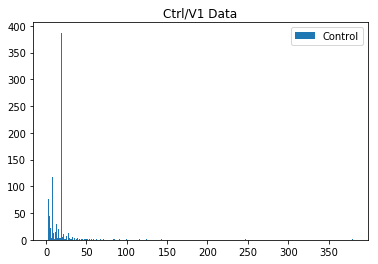

In [210]:
plt.hist(ad_control.iloc[:,-1], bins=np.arange(min(ad_control.iloc[:,-1])+1, max(ad_control.iloc[:,-1]) + 1, 1), label='Control')
# plt.hist(ad_control_iap_rev, label='Control')
plt.title('Ctrl Data')
plt.legend()
plt.show()

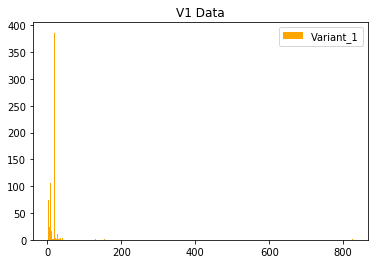

In [211]:
plt.hist(ad_variant_1_iap_rev, bins=np.arange(min(ad_variant_1.iloc[:,-1])+1, max(ad_variant_1.iloc[:,-1]) + 1, 1),label='Variant_1', color='orange')
plt.title('V1 Data')
plt.legend()
plt.show()

In [172]:
iOS = df.loc[df['PLAT'] == 'iOS']
ios_rev = iOS.loc[:,['PLAT','BUMP_REVENUE','PROMOTION_REVENUE','SUB_REVENUE']]
ios_rev = ios_rev[(ios_rev.BUMP_REVENUE != 0.0) | (ios_rev.PROMOTION_REVENUE != 0.0) | (ios_rev.SUB_REVENUE != 0.0)]
ios_rev['IAP_REVENUE'] = ios_rev.iloc[:,1:].sum(axis=1)
ios_rev.head(10)

,PLAT,BUMP_REVENUE,PROMOTION_REVENUE,SUB_REVENUE,IAP_REVENUE
1015,iOS,0.00,2.99,0.00,2.99
1022,iOS,0.00,2.99,0.00,2.99
1101,iOS,0.00,0.00,19.99,19.99
1136,iOS,0.00,0.00,19.99,19.99
1147,iOS,0.00,2.99,0.00,2.99
1152,iOS,1.99,0.00,0.00,1.99
1247,iOS,0.00,0.00,19.99,19.99
1313,iOS,0.00,3.99,0.00,3.99
1319,iOS,0.00,23.97,0.00,23.97
1328,iOS,0.00,0.00,19.99,19.99


# Bootstrap with Numpy

In [218]:
ctrl = ad_control_iap_rev
test = ad_variant_1_iap_rev
num_iterations = 10000
bootstrapped_means_ctrl = []
bootstrapped_means_test = []
for i in range(num_iterations):
    data_bootstrap_ctrl = np.random.choice(ctrl, size=ctrl.shape[0], replace=True)
    data_bootstrap_test = np.random.choice(test, size=test.shape[0], replace=True)
    ctrl_mean = np.mean(data_bootstrap_ctrl)
    test_mean = np.mean(data_bootstrap_test)
    bootstrapped_means_ctrl.append(ctrl_mean)
    bootstrapped_means_test.append(test_mean)
bootstrapped_means_ctrl = np.array(bootstrapped_means_ctrl)
bootstrapped_means_test = np.array(bootstrapped_means_test)
bootstrapped_means_diff = bootstrapped_means_test - bootstrapped_means_ctrl

two tailed stat sig test, null hypothesis of no difference

In [219]:
alpha=0.05
low = np.percentile(bootstrapped_means_diff, 100 * (alpha / 2.))
val = np.percentile(bootstrapped_means_diff, 50)
high = np.percentile(bootstrapped_means_diff, 100 * (1 - alpha / 2.))
x_bar = np.mean(test) - np.mean(ctrl)
print('{}\t({}, {})'.format(val,low,high))
print('p-value: {}'.format(min(2*np.sum(bootstrapped_means_diff < 0)/bootstrapped_means_diff.shape[0],
                               2*np.sum(bootstrapped_means_diff > 0)/bootstrapped_means_diff.shape[0])))

-0.07085571807218027	(-2.004140512975044, 2.3588344298885158)
p-value: 0.9466


# Bootsrap with PySpark

each data frame includes all users and metrics from a given experiment and variant

this assumes a dense dataset where most users have non-zero values for the metric (e.g. clicks)

in the case of a sparse metric (e.g. shipment) see the trick below to speed up sampling

In [21]:
sdf_ctrl = sqlCtx.createDataFrame(pd.DataFrame({'metric_1': ctrl, 'metric_2': 2*ctrl}))
sdf_test = sqlCtx.createDataFrame(pd.DataFrame({'metric_1': test, 'metric_2': 2*test}))

In [22]:
bootstrapped_means_diff = []
# TODO: this for loop could be parallelized
for i in range(num_iterations):
    bootstrap_ctrl = sdf_ctrl.sample(withReplacement=True, fraction=1.0)
    bootstrap_test = sdf_test.sample(withReplacement=True, fraction=1.0)
    ctrl_mean = np.array(bootstrap_ctrl.select(*[functions.mean(col) for col in bootstrap_ctrl.columns]).collect())
    test_mean = np.array(bootstrap_test.select(*[functions.mean(col) for col in bootstrap_test.columns]).collect())
    means_diff = test_mean - ctrl_mean
    bootstrapped_means_diff.append(means_diff)
bootstrapped_means_diff = np.array(bootstrapped_means_diff)

two tailed stat sig test, null hypothesis of no difference for metric 1

In [23]:
low = np.percentile(bootstrapped_means_diff[0], 100 * (alpha / 2.))
val = np.percentile(bootstrapped_means_diff[0], 50)
high = np.percentile(bootstrapped_means_diff[0], 100 * (1 - alpha / 2.))
print('{}\t({}, {})'.format(val,low,high))
print('p-value: {}'.format(min(2*np.sum(bootstrapped_means_diff[0] < 0)/bootstrapped_means_diff.shape[0],
                               2*np.sum(bootstrapped_means_diff[0] > 0)/bootstrapped_means_diff.shape[0])))

0.07984429670493864	(0.054560269415041406, 0.10512832399483589)
p-value: 0.0


# Notes / References

**note on case of sparse data from facebook implementation --**

in the sparse case we dont actually need to bootstrap
the full sparse array since most values are 0
instead for each bootstrap iteration we:
   1. generate B number of non-zero entries to sample from the binomial distribution with n = all users buckets and p = proportion of users with non-zero entries
   2. resample with replacement the non-zero entries from values B times
   3. create a new sparse array with the B resamples, zero otherwise

**references**
* http://faculty.psy.ohio-state.edu/myung/personal/course/826/bootstrap_hypo.pdf
* https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
* https://github.com/facebookincubator/bootstrapped/blob/master/bootstrapped/bootstrap.py
* https://fullstackml.com/how-to-check-hypotheses-with-bootstrap-and-apache-spark-cd750775286a